In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pymatgen import units

from scipy.constants import Boltzmann, electron_volt
from sympy import symbols
from sympy.vector import CoordSys3D

import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from ruamel.yaml import YAML
yaml = YAML()

from neighbormodels.structure import from_file
from neighbormodels.neighbors import count_neighbors
from neighbormodels.interactions import build_model
import neighbormodels as nm

kB = 1000 * Boltzmann / electron_volt

pd.set_option("display.colheader_justify", "left")
pd.set_option("display.html.border", 0)
html_table_style = {"selector": "th", "props": [("text-align", "left")]}

In [2]:

def pattern_tables( layer, p_type):
    """
    Places the manetic patterns in the correct order relative to the structure file.
    
    Parameters:
    layer - magnetic patterns read in from file
    p_type - pre-fix for pattern
    """
    n_row, n_column = layer.shape
    au_layer = pd.DataFrame(np.zeros((2,n_column)))
    patterns = pd.concat([ layer[0:1],au_layer,
                           layer[1:2],au_layer,
                           layer[2:3],au_layer,
                           layer[3:4],au_layer,
                           layer[4:5],au_layer,
                           layer[5:6],au_layer,
                           layer[6:7],au_layer,
                           layer[7:8],au_layer], ignore_index=True)
    
    p_types =[]
    p_types.append("nm")
    index = np.arange(1,len(patterns.columns))
    for i in index:
        p_types.append(p_type+str(i))
    patterns.columns = p_types
    
    return patterns


def update_neighbors_data_frame(a, distances_list):
    """
    Updates the neighbor_data.data_frame to include only the Mn neighbor atoms 
    in the distances of interest.
    
    Parameters:
    
    a - neighbor_data.data_frame generated by count_neighbors function
    distances_list - list of distances of Mn neighbor atoms to consider
    
    """
    nn_distances = np.array(distances_list["distance"])
    idx_list_a = []
    for i in range(len(a['distance_bin'])):
        for j in nn_distances:
            if j in a['distance_bin'][i]:
                idx_list_a.append(i)
    drop_list_a = np.arange(len(a))
    drop_list_a = [i for i in drop_list_a if i not in idx_list_a]
    
    return a.drop(drop_list_a).reset_index(drop=True)

def neighbor_data_mod(structure_mnau2, distances_list):
    
    """
    Modifies the neighbor_data input with the update neighbor_data.data_frame
    
    Parameters:
    structure_mnau2 - pymatgen structure as read from .cif file
    distances_list - list of distances of Mn neighbor atoms to consider
    
    """
    k = nm.neighbors.NeighborData
    neighbor_data = count_neighbors(cell_structure=structure_mnau2, r=18.0)

    k.data_frame = neighbor_data.data_frame \
        .merge(neighbor_data.data_frame.rename(columns={"j": "i", "i": "j"}), how="outer") \
        .sort_values(["i","distance_bin", "j"]) \
         .query("subspecies_i != 'Au'")\
            .query("subspecies_j != 'Au'")#\
  #          .reset_index(drop=True)

    k.data_frame = update_neighbors_data_frame(k.data_frame, distances_list)

    k.bins_data_frame = neighbor_data.bins_data_frame
    k.count = neighbor_data.count
    k.index = neighbor_data.index
    k.structure = neighbor_data.structure
    
    return k

def drop_duplicate_energies(qe_energies):
    """
    Checks that energies are unique (not within tolerance value of each other)
    
    Parameters:
    
    qe_energies - list of energ values (read from file)
    
    """
    qe_energies.columns = ["pattern", "num_sites", "total_energy" ]
    ryd_to_ev = 13.605693009 #eV 
    tol = 0.0001 #eV

    #convert to eV
    qe_energies["total_energy"] = qe_energies["total_energy"]*ryd_to_ev

    for i in range(len(qe_energies)-1):
        for j in range(1+1,len(qe_energies)):
            if (i != j):
                diff = abs(qe_energies["total_energy"][i] - qe_energies["total_energy"][j])
                if (  diff  <= tol ):
                    qe_energies["pattern"][j] = qe_energies["pattern"][i]
                    #print (i,j, qe_energies["total_energy"][i], qe_energies["total_energy"][j], diff)
                
                
    #drop repeating energies            
    qe_energies = qe_energies.reset_index(drop=True).drop_duplicates(["pattern"], keep="first")           
 
    #convert back to Rydberg
    qe_energies["total_energy"] = qe_energies["total_energy"]/ryd_to_ev
    
    return qe_energies

def mg_moments_check(mg_moments, qe_energies):
    
    """
    Checks for no lost magnetic moments
    
    Parameters:
    
    mg_moments - table of magnetic moments read from file
    qe_energies - table of energies read from file
    
    """
    n_row, n_column = mg_moments.shape
    mg_moments = pd.DataFrame(round (abs(mg_moments/4.0)).sum(axis=0), columns=["total_moment"])
    mg_moments = pd.concat ([qe_energies['pattern'], mg_moments['total_moment']], axis=1)
    
    return mg_moments[(mg_moments['total_moment'] != n_row ) & (mg_moments['pattern'] != "nm") ] #.head()

#### Read in structure files and the table of distances for the Mn nearest neighbors:

In [3]:
cif_filepath1 = "data/mn8au16_collinear.cif"
cif_filepath2 = "data/mn8au16_1x1x4.cif"
structure_mnau2_c = from_file(structure_file=cif_filepath1)
structure_mnau2_z = from_file(structure_file=cif_filepath2)

distances_list=pd.read_csv('data/distances.csv-bak', header=None)
distances_list.columns= ['pattern','central_atom','neighbor_atom','distance']
distances_list

/home/ssilayi/anaconda3/lib/python3.6/site-packages/pymatgen/core/lattice.py:694: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(q.T, p.T)[0].T


,pattern,central_atom,neighbor_atom,distance
0,c,1,4,3.37
1,c,1,6,4.77
2,c,1,5,6.74
3,c,1,7,7.54
4,z,1,13,4.99
5,z,1,2,8.76
6,z,1,14,13.36
7,z,1,3,17.52


#### Using the structure files and distances list to update the output of count_neighbors. The updated input (modified neighbor_data.data_frame contains only the atom pairs in the distances of interest. This is the new input for build_model, which takes the magnetic patterns and the modified data_frame to generate the exchange model.

In [ ]:
def neighbor_data_mod(structure_mnau2, distances_list):
    
    """
    Modifies the neighbor_data input with the update neighbor_data.data_frame
    
    Parameters:
    structure_mnau2 - pymatgen structure as read from .cif file
    distances_list - list of distances of Mn neighbor atoms to consider
    
    """
    k = nm.neighbors.NeighborData
    neighbor_data = count_neighbors(cell_structure=structure_mnau2, r=18.0)

    k.data_frame = neighbor_data.data_frame \
        .merge(neighbor_data.data_frame.rename(columns={"j": "i", "i": "j"}), how="outer") \
        .sort_values(["i","distance_bin", "j"]) \
         .query("subspecies_i != 'Au'")\
            .query("subspecies_j != 'Au'")#\
  #          .reset_index(drop=True)

    k.data_frame = update_neighbors_data_frame(k.data_frame, distances_list)

    k.bins_data_frame = neighbor_data.bins_data_frame
    k.count = neighbor_data.count
    k.index = neighbor_data.index
    k.structure = neighbor_data.structure
    
    return k


In [5]:
c_layer=pd.read_csv('data/mg_collinear_patterns', header=None)
c_patterns = pattern_tables( c_layer, "c-")
k_c = neighbor_data_mod(structure_mnau2_c, distances_list)
exchange_model_c = build_model(magnetic_patterns=c_patterns, neighbor_data=k_c)

z_layer=pd.read_csv('data/mg_1x1x4_patterns', header=None)
z_patterns = pattern_tables( z_layer, "z-")
k_z = neighbor_data_mod(structure_mnau2_z, distances_list)
exchange_model_z = build_model(magnetic_patterns=z_patterns, neighbor_data=k_z)

AttributeError: 'NeighborData' object has no attribute 'data_frame'

In [6]:
k = nm.neighbors.NeighborData
k.structure

#### Combining the two exchange_model matrices into one large one. The number of neighbor energies listed is up to J8, same as the number of neighbors of interest in the distances_list.

In [6]:
#combine the 2 cases
exchange_model_all = pd.concat([exchange_model_c, exchange_model_z])\
                     .reset_index(drop=True)

exchange_model_all.to_csv("data/exchange_model.csv")    
exchange_model_all.head()


,pattern,J1,J2,J3,J4,J5,J6,J7,J8
0,c-1,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.666667,0.666667
1,c-10,-0.333333,0.000000,0.333333,0.000000,-0.666667,0.000000,0.333333,0.666667
2,c-11,-0.333333,0.000000,0.333333,0.000000,-0.666667,0.000000,0.333333,0.666667
3,c-12,0.333333,0.000000,1.000000,0.000000,0.666667,0.000000,1.000000,0.666667
4,c-13,0.000000,-1.333333,0.000000,1.333333,0.000000,-0.666667,0.000000,0.666667


In the next 2 steps, energies are read in and checked to eliminate any that duplicate. 
The magnetic moment from the calculations is also checked to make sure noe of the patterns lose it.

In [7]:
#Calculated energies from QE for the different patterns are tabulated and read in
qe_energies1 = pd.read_csv('data/energy.out.collinear.csv', header=None)
qe_energies_c = drop_duplicate_energies(qe_energies1) 

qe_energies2 = pd.read_csv('data/energy.out.1x1x4.csv', header=None)
qe_energies_z = drop_duplicate_energies(qe_energies2)    

#combine all energies
qe_energies_all = pd.concat([qe_energies_c, qe_energies_z])
qe_energies_all = qe_energies_all.reset_index(drop=True).drop_duplicates(["pattern"], keep="first") 
qe_energies_all.head()

/home/ssilayi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,pattern,num_sites,total_energy
0,nm,24,-14691.879405
1,c-1,24,-14693.951620
2,c-2,24,-14693.957454
3,c-3,24,-14693.970500
4,c-4,24,-14693.947722


In [8]:
#read in magnetic moments and return any that don't have the expected total magnetic moment (18)
mg_moments_c = pd.read_csv('data/mg_moment.collinear',sep='\t', header=None)
zero_moments_c = mg_moments_check(mg_moments_c, qe_energies_c)
#zero_moments_c

mg_moments_z = pd.read_csv('data/mg_moment.1x1x4',sep='\t', header=None)
zero_moments_z = mg_moments_check(mg_moments_z, qe_energies_z)
#zero_moments_z

#### The combined energies and exchange model matrices are put together for fitting of parameters:

In [9]:
def ModelMatrix(qe_energies, exchange_model):
    model_matrix = qe_energies \
        .assign(energy = lambda x:
            (x["total_energy"] -
             np.float64(x.query("pattern == 'nm'").loc[:, "total_energy"])) *
            1000 * units.Ry_to_eV / x["num_sites"])  \
        .merge(exchange_model, on=["pattern"]) \
        .query("pattern != 'nm'") \
        .assign(J1 = lambda x: x["J1"]) \
        .assign(J2 = lambda x: x["J2"]) \
        .assign(J3 = lambda x: x["J3"]) \
        .assign(J4 = lambda x: x["J4"]) \
        .assign(J5 = lambda x: x["J5"]) \
        .assign(J6 = lambda x: x["J6"]) \
        .assign(J7 = lambda x: x["J7"]) \
        .assign(J8 = lambda x: x["J8"]) \
        .loc[:, ["pattern", "energy", "J1", "J2", "J3", "J4", "J5" , "J6", "J7","J8"]]

    return model_matrix

model_matrix = ModelMatrix(qe_energies_all, exchange_model_all)\
               .reset_index(drop=True) \
               .drop(["pattern"], axis=1) 

model_matrix.head()
#model_matrix.tail()

,energy,J1,J2,J3,J4,J5,J6,J7,J8
0,-1174.746731,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.666667,0.666667
1,-1178.053822,0.333333,0.000000,1.000000,0.000000,0.666667,0.000000,1.000000,0.666667
2,-1185.449491,0.666667,0.666667,1.666667,0.666667,1.333333,0.333333,1.666667,0.666667
3,-1172.536486,-0.666667,0.666667,0.333333,0.666667,-1.333333,0.333333,0.333333,0.666667
4,-1171.773150,-0.333333,0.000000,0.333333,0.000000,-0.666667,0.000000,0.333333,0.666667


#### Parameters are fit (comparing 2 methods):

In this case, the values for the two come out different. Need to go over calculations again to make sure everything
works as intended (haven't found anything yet)

In [10]:
smf_exchange_fit = smf.ols(data=model_matrix, formula="energy ~ J1 + J2 + J3 + J4 +J5 + J6 + J7 + J8 ").fit()
smf_exchange_parameters = pd.DataFrame(smf_exchange_fit.params, columns=["stats_models"])
#smf_exchange_parameters


In [11]:
lm = LinearRegression()
lm_exchange_fit = lm.fit(X=model_matrix[["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]], y=model_matrix["energy"])
lm_exchange_parameters = pd.DataFrame({
    "sklearn": [lm_exchange_fit.intercept_, 
                lm_exchange_fit.coef_[0], lm_exchange_fit.coef_[1],lm_exchange_fit.coef_[2],
                lm_exchange_fit.coef_[3], lm_exchange_fit.coef_[4],lm_exchange_fit.coef_[5],
                lm_exchange_fit.coef_[6], lm_exchange_fit.coef_[7]]},
    index=["Intercept", "J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"],
)
#lm_exchange_parameters

In [12]:
exchange_parameters = pd.concat([smf_exchange_parameters,lm_exchange_parameters], axis=1)
#save to file    
exchange_parameters.to_csv("data/mnau2_exchange_parameters.select_neighbors.txt", sep=' ')
exchange_parameters

,stats_models,sklearn
Intercept,-696.296536,-1.187800e+03
J1,53.787824,-8.236695e-01
J2,-7.283060,-7.283060e+00
J3,-137.341047,-8.123141e-01
J4,2.982284,2.982284e+00
J5,107.575647,-1.647339e+00
J6,273.068821,1.135533e-02
J7,-137.341047,-8.123141e-01
J8,-464.197691,-1.666008e-30


#### The parameters are supposed to reproduce the calculated total energies 

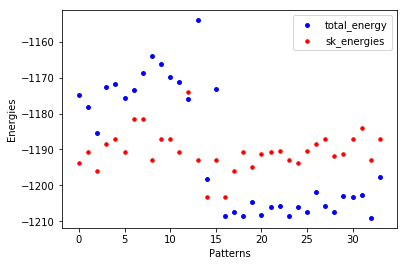

In [13]:
sk_par = lm_exchange_parameters.drop(lm_exchange_parameters.index[0])
sk_intercept = lm_exchange_parameters["sklearn"].values[0]
ss_par = smf_exchange_parameters.drop(smf_exchange_parameters.index[0])
ss_intercept = smf_exchange_parameters["stats_models"].values[0]
par_table =["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
neighbor_energies = model_matrix[par_table].copy().reset_index(drop=True)

a = neighbor_energies.values 

b = ss_par.transpose().values
ss_energies = np.sum(a*b, axis =1 ) + ss_intercept

b = sk_par.transpose().values
sk_energies = np.sum(a*b, axis =1 ) + sk_intercept

energies = pd.DataFrame()
energies["total_energy"] = model_matrix["energy"]
energies["ss_energies"] = ss_energies
energies["sk_energies"] = sk_energies


#features=["total_energy", "ss_energy", "sk_energy"]
x = range(len(energies))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, energies.total_energy, s=15, c='b', label='total_energy')
ax.scatter(x, energies.sk_energies, s=12, c='r', label='sk_energies')
plt.ylabel('Energies')
plt.xlabel('Patterns')
plt.legend();
plt.show()


### Cross Validation

In [14]:
data = model_matrix.copy()
data.head()

,energy,J1,J2,J3,J4,J5,J6,J7,J8
0,-1174.746731,0.000000,0.666667,0.666667,0.000000,0.000000,0.000000,0.666667,0.666667
1,-1178.053822,0.333333,0.000000,1.000000,0.000000,0.666667,0.000000,1.000000,0.666667
2,-1185.449491,0.666667,0.666667,1.666667,0.666667,1.333333,0.333333,1.666667,0.666667
3,-1172.536486,-0.666667,0.666667,0.333333,0.666667,-1.333333,0.333333,0.333333,0.666667
4,-1171.773150,-0.333333,0.000000,0.333333,0.000000,-0.666667,0.000000,0.333333,0.666667


In [15]:
#check the values of energies predicted from the sk_fit parameters vs. the starting values:
parameters = ["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
energy_predict = pd.DataFrame()
energy_predict["energy_calc"] = data.energy 
for i in range(1, 9):
    pars_to_fit = parameters[:i]    
    sk_fit = lm.fit(X=data[pars_to_fit], y=data.energy)
    energy_predict[f"energy_{i}"] = sk_fit.predict(data[pars_to_fit])
    
energy_predict.head()

,energy_calc,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8
0,-1174.746731,-1189.871088,-1194.306365,-1194.410948,-1193.738432,-1193.738432,-1193.738432,-1193.738432,-1193.738432
1,-1178.053822,-1192.591563,-1190.667454,-1190.665696,-1190.797384,-1190.797384,-1190.797384,-1190.797384,-1190.797384
2,-1185.449491,-1195.312039,-1197.150804,-1197.140580,-1196.116651,-1196.116651,-1196.116651,-1196.116651,-1196.116651
3,-1172.536486,-1184.430137,-1191.461927,-1191.435287,-1188.459350,-1188.459350,-1188.459350,-1188.459350,-1188.459350
4,-1171.773150,-1187.150612,-1187.823016,-1187.813049,-1186.968734,-1186.968734,-1186.968734,-1186.968734,-1186.968734


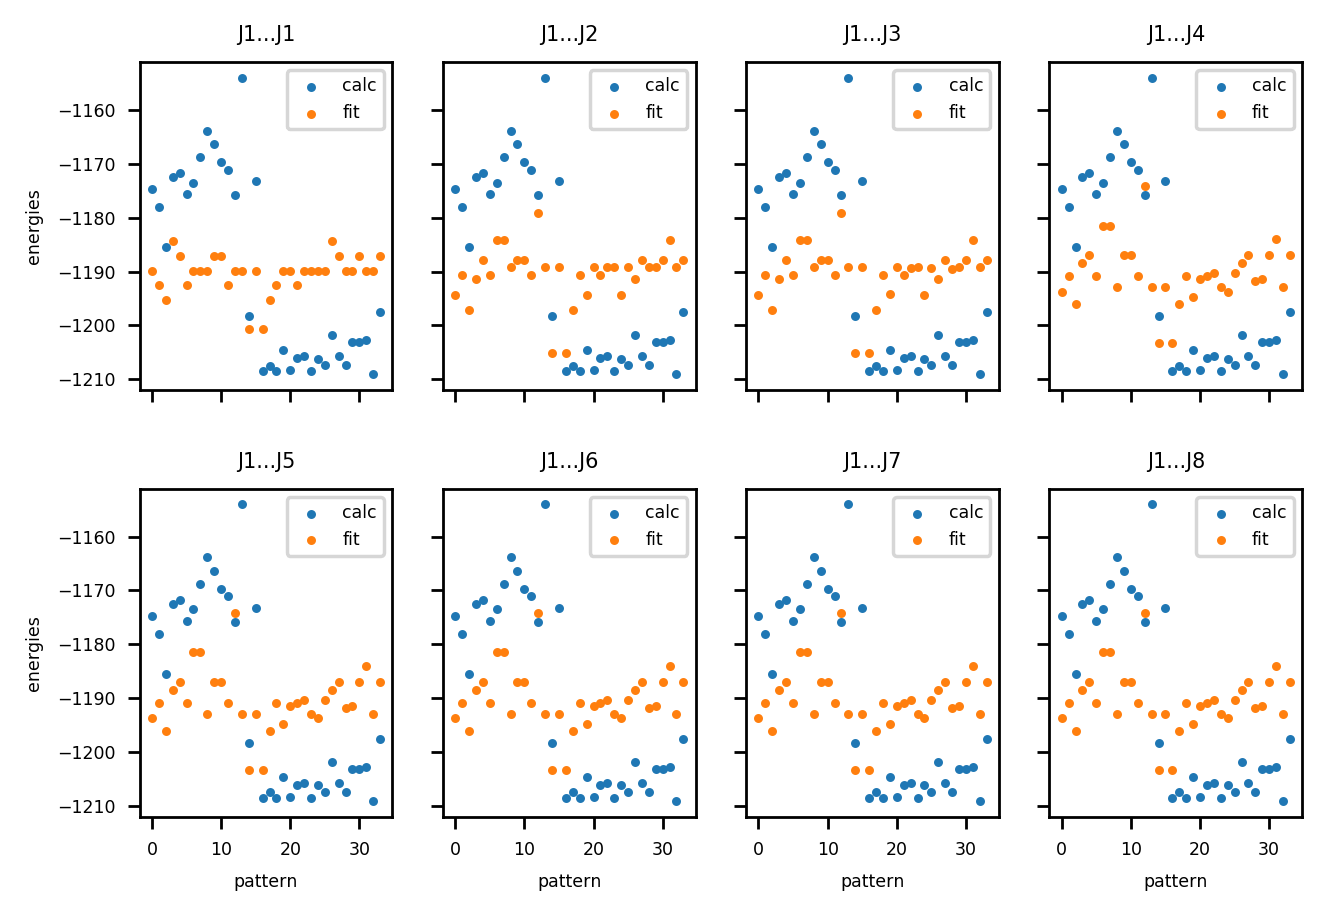

In [16]:
plt.rcParams.update({'font.size': 5})
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', dpi=250)
fig.subplots_adjust(hspace=0.3)
k = 1
for i in range(2):
    for j in range(4):
        p_e = "energy_"+str(k)
        J = "J" + str(1)+"...J"+str(k)
        ax[i, j].scatter(x= range(len(data) ), y="energy_calc", data=energy_predict, label = "calc", s=2.5)
        ax[i, j].scatter(x= range(len(data) ), y=p_e, data=energy_predict, label = "fit", s=2.5)
        ax[i, j].set_title(J)
        ax[i, j].set(xlabel='pattern', ylabel='energies')
        ax[i, j].legend()
        k = k+1
        
for aij in ax.flat:
    aij.label_outer()

 #### Loop over  different number of J parameters, use repeated k-fold cross validation to score the models: k = 4, repeats = 100

In [51]:
#checking for reasonable k
from sklearn.model_selection import KFold
parameters = np.array([1,2,3,4,5,6,7,8])

#for i in range(10):
kfold = KFold(4, True, 1)
# enumerate splits
for train, test in kfold.split(parameters):
    print('train: %s, test: %s' % (parameters[train], parameters[test]))

train: [1 2 4 5 6 7], test: [3 8]
train: [1 3 4 5 6 8], test: [2 7]
train: [2 3 4 6 7 8], test: [1 5]
train: [1 2 3 5 7 8], test: [4 6]


In [54]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
lm = LinearRegression()

scores = {
    "n": [],
    "mse_trace": [],
    "mse_mean": [],
    "mse_sd": [],
    "r**2_trace": [],
    "r**2_mean": [],
    "r**2_sd": [],
}

parameters = ["J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"]
energy_predict = pd.DataFrame()
energy_predict["energy_calc"] = data.energy 
for n in range(1, 9):
    x = data[parameters[:n]]    
    y = data.energy
    
    rkf = RepeatedKFold(
        n_splits=4,
        n_repeats=100,
        random_state=int(np.round(np.random.uniform(0, 2**31), decimals=0)),
    )
    
    # Cross-validated mean-squared error score
    mse_cv_score = cross_val_score(
        lm,
        x, y,
        scoring="neg_mean_squared_error",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )
    
     # Cross-validated R**2 score
    r2_cv_score = cross_val_score(
        lm,
        x, y,
        scoring="r2",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )
    
    scores["n"].append(n)
    scores["mse_trace"].append(mse_cv_score)
    scores["mse_mean"].append(np.mean(mse_cv_score))
    scores["mse_sd"].append(np.std(mse_cv_score))
    scores["r**2_trace"].append(r2_cv_score)
    scores["r**2_mean"].append(np.mean(r2_cv_score))
    scores["r**2_sd"].append(np.std(r2_cv_score))



##### Model Performance scores

In [55]:
n_par_scores = pd.DataFrame(scores)
n_par_scores[["n", "mse_mean", "mse_sd", "r**2_mean", "r**2_sd"]]


,n,mse_mean,mse_sd,r**2_mean,r**2_sd
0,1,-325.635805,77.314616,-0.633918,6.490899
1,2,-325.600218,77.386161,-0.212182,0.397117
2,3,-364.143549,102.509232,-0.426565,0.979230
3,4,-391.731861,137.921090,-0.639775,3.234461
4,5,-392.622960,139.338317,-0.636804,2.401761
5,6,-386.347509,132.956026,-0.474992,0.745492
6,7,-391.939385,142.257693,-1.282631,10.782305
7,8,-387.107639,121.306798,-0.908705,4.980344


#### Distribution of cross-validation scores 

In [65]:
cv_scores_dist = pd.concat([
          pd.DataFrame(n_par_scores["mse_trace"].tolist())\
          .assign(n=range(1, 9), score = "mse") \
          .melt(id_vars=["n", "score"], 
                value_vars=list(range(400)), var_name="cv_run", value_name="value")\
          .sort_values(["score", "n", "cv_run"]) \
          .reset_index(drop=True),
          pd.DataFrame(n_par_scores["r**2_trace"].tolist())\
          .assign(n=range(1, 9), score = "r**2") \
          .melt(id_vars=["n", "score"], 
                value_vars=list(range(400)), var_name="cv_run", value_name="value")\
          .sort_values(["score", "n", "cv_run"]) \
          .reset_index(drop=True) 
])

mse_scores_dist = cv_scores_dist \
    .query("score == 'mse' ") \
    .loc[:, ["n", "value"]] \
    .rename(columns={"n": "#_of_J"}) \
    .reset_index(drop=True)
    
r2_scores_dist = cv_scores_dist \
    .query("score == 'r**2'") \
    .loc[:, ["n", "value"]] \
    .rename(columns={"n": "#_of_J"}) \
    .reset_index(drop=True)

#mse_bin= np.linspace(mse_scores_dist.value.min(), mse_scores_dist.value.max(), 20)
#r2_bin = np.linspace(r2_scores_dist.value.min(), r2_scores_dist.value.max(), 20)

 - mean-squared error scores distribution for different numbers of J in calculation:

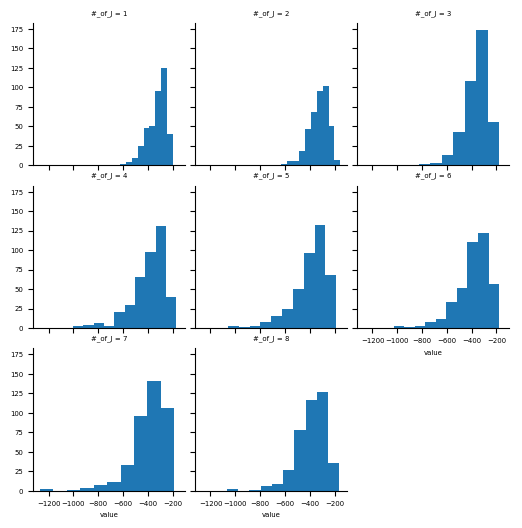

In [66]:
g = sns.FacetGrid(mse_scores_dist, 
                   col = "#_of_J", 
                   col_wrap=3, 
                   sharex=True,
                   sharey=True
                  )
g.map(plt.hist, "value")

g.fig.set_dpi(100)
g.fig.set_size_inches(5, 5);


- $R^2$ scores distribution for different numbers of J in calculation:

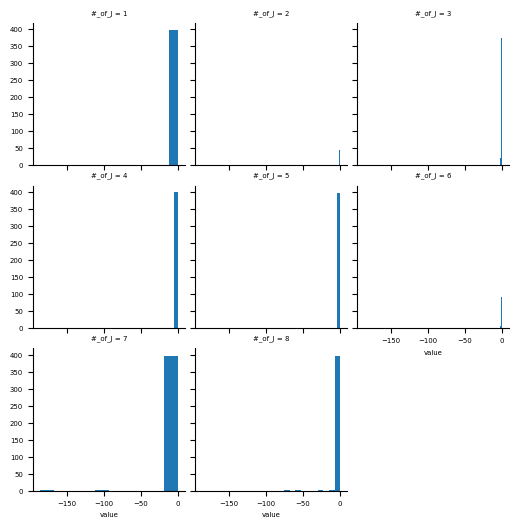

In [67]:
g = sns.FacetGrid(r2_scores_dist, 
                   col = "#_of_J", 
                   col_wrap=3, 
                   sharex=True,
                   sharey=True
                  )
g.map(plt.hist, "value")

g.fig.set_dpi(100)
g.fig.set_size_inches(5, 5);

#### Resampling (bootstrapping) to determine error bars

In [72]:
bootstrap_results = {
    "n": [],
    "sample": [],
    "mean": [],
}

for n in range(0, 9):
    bootstrap_series = cv_scores_dist \
        .query(f"score == 'mse' & n == '{n}'") \
        .sample(frac=1000, replace=True).loc[:, "value"]
    bootstrap_df = pd.DataFrame(bootstrap_series) \
        .assign(sample_id=[f"{x}" for x in range(400) for _ in range(400)])
    bootstrap_mean_samples = bootstrap_df \
        .groupby(["sample_id"]) \
        .mean() \
        .loc[:, "value"] \
        .values

    bootstrap_results["n"].extend(1000 * [f"{n}"])
    bootstrap_results["sample"].extend(list(range(1000)))
    bootstrap_results["mean"].extend(bootstrap_mean_samples)

cv_scores_bootstrap = pd.DataFrame(bootstrap_results)
cv_scores_bootstrap.head()

ValueError: Length of values does not match length of index

In [64]:
mse_ci_95 = cv_scores_bootstrap \
    .loc[:, ["n", "mean"]] \
    .groupby(["n"]) \
    .quantile([0.025, 0.975])
mse_ci_95 = mse_ci_95["mean"] \
    .unstack() \
    .reset_index() \
    .rename(columns={0.025: "lower", 0.975: "upper"})
    
#merge
cv_final = n_par_scores.copy().loc[:, ["n", "mse_mean"]].query("n > 1")
cv_final["n"] = cv_final["n"].astype(str)
cv_final = cv_final.merge(mse_ci_95, on=["n"])


#length of yerror bars
cv_final["yerr_lower"] = np.abs(cv_final["mse_mean"] - cv_final["lower"])
cv_final["yerr_upper"] = np.abs(cv_final["mse_mean"] - cv_final["upper"])

#bootstrap distributions for the mean-squared error score 
cv_final

,n,mse_mean,lower,upper,yerr_lower,yerr_upper
0,2,-325.600218,-328.925688,-314.063896,3.325470,11.536322
1,3,-364.143549,-361.997530,-343.602960,2.146019,20.540588
2,4,-391.731861,-382.733250,-358.552887,8.998611,33.178973
3,5,-392.622960,-379.120296,-355.930569,13.502664,36.692391
4,6,-386.347509,-378.618794,-356.261823,7.728715,30.085687
5,7,-391.939385,-381.954417,-360.134137,9.984968,31.805248
6,8,-387.107639,-379.184765,-357.439223,7.922874,29.668415


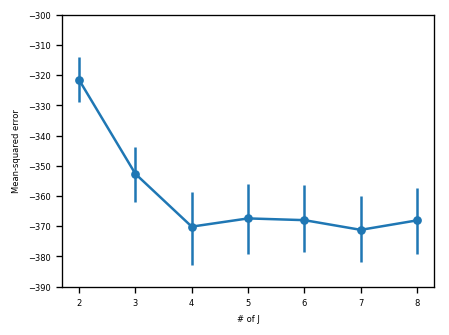

In [25]:
#visualize
ig, ax = plt.subplots(dpi=120, figsize=(4, 3))
facet_var, facet_id, facet_label, facet_ylim = ("mse", 0, r"Mean-squared error", (-390.00, -300.0))
sns.scatterplot(
    x="n",
    y=f"{facet_var}_mean",
    data=cv_final,
    ax=ax,
)
ax.errorbar(
    cv_final["n"],
    cv_final[f"{facet_var}_mean"],
    yerr=[cv_final["yerr_lower"], cv_final["yerr_upper"]],
)
ax.set_ylim(facet_ylim)
ax.set_xlabel(r"# of J")
ax.set_ylabel(facet_label)

fig.tight_layout();

In [26]:
cv_final.n = cv_final["n"].astype(int)

cv_final2 = cv_scores_dist \
    .query("score == 'mse'") \
    .loc[:, ["n", "value"]] \
    .groupby(["n"]) \
    .quantile([0.025, 0.975]) \
    .loc[:, "value"] \
    .unstack() \
    .reset_index() \
    .rename(columns={0.025: "dist_lower", 0.975: "dist_upper"}) \
    .merge(cv_final, on="n") \
    .assign(yerr_dist_lower=lambda x: np.abs(x.dist_lower - x.mse_mean),
            yerr_dist_upper=lambda x: np.abs(x.dist_upper - x.mse_mean),
            n=lambda x: x.n.astype(int)) \
    .sort_values(["n"]) \
    .reset_index(drop=True) 

    
cv_final2

,n,dist_lower,dist_upper,mse_mean,lower,upper,yerr_lower,yerr_upper,yerr_dist_lower,yerr_dist_upper
0,2,-638.868245,-147.714475,-321.511661,-328.925688,-314.063896,7.414027,7.447765,317.356584,173.797186
1,3,-717.972216,-159.959559,-352.640142,-361.997530,-343.602960,9.357388,9.037182,365.332073,192.680584
2,4,-862.275191,-153.968829,-370.123874,-382.733250,-358.552887,12.609375,11.570987,492.151316,216.155045
3,5,-839.789640,-132.690554,-367.398217,-379.120296,-355.930569,11.722078,11.467648,472.391423,234.707663
4,6,-866.133819,-148.448291,-367.975730,-378.618794,-356.261823,10.643064,11.713908,498.158089,219.527439
5,7,-856.611389,-145.489466,-371.187299,-381.954417,-360.134137,10.767118,11.053162,485.424090,225.697833
6,8,-816.898065,-152.557062,-368.040498,-379.184765,-357.439223,11.144267,10.601275,448.857567,215.483436


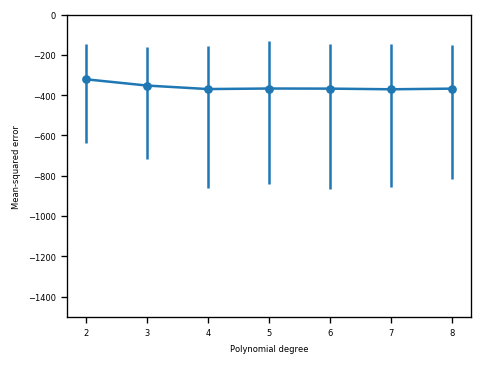

In [27]:
#mean-squared error scores along with error bars that represent
#the spread of the cross-validation results (specifically, the middle 95%).

fig, ax = plt.subplots(dpi=120, figsize=(4, 3))
facet_var, facet_id, facet_label, facet_ylim = ("mse", 0, r"Mean-squared error", (-1500.00, -00.0))
sns.scatterplot(
    x="n",
    y=f"{facet_var}_mean",
    data=cv_final2,
    ax=ax,
)
ax.errorbar(
    cv_final2["n"],
    cv_final2[f"{facet_var}_mean"],
    yerr=[cv_final2["yerr_dist_lower"], cv_final2["yerr_dist_upper"]],
)
ax.set_ylim(facet_ylim)
ax.set_xlabel(r"Polynomial degree")
ax.set_ylabel(facet_label)

fig.tight_layout();